#  XPCS pipepline 

Get the data from the databroker

In [11]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler

 ### Easily switch between interactive and static matplotlib plots

In [24]:
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

In [2]:
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

class FixedEigerImages(EigerImages):
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs

    def __init__(self, fpath, frame_per_point):
        # create pims handler
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        # TODO Return a multi-dimensional PIMS seq.
        return FixedEigerImages(master_path)

register_handler('AD_EIGER', LazyEigerHandler)  # Register it so filestore knows to use it.

In [6]:
events = get_events(db['e59f567d'], ['eiger_4M_cam_img_image_lightfield'])
ev = next(events)

In [9]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
imgs

<Frames>
Length: 3000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

In [20]:
#plt.imshow(imgs[0], interpolation='nearest', cmap='viridis', vmin=0, vmax=1e0)

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

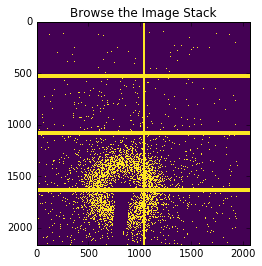

In [31]:
from ipywidgets import interact

def view_image(i):
    plt.imshow(imgs[i], interpolation='nearest', cmap='viridis', vmin=0, vmax=1e0)
    plt.title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, 2999)) 

### Get the Averaged Image Data

<IPython.core.display.Javascript object>


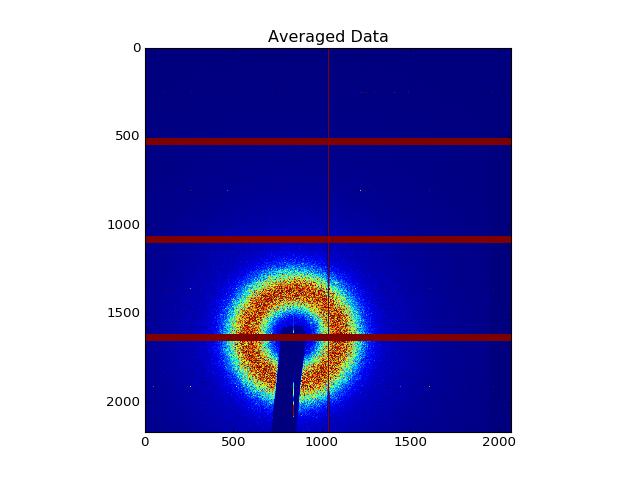

In [34]:
avg_img = np.average(imgs, axis=0)

# Plot the result
fig, ax = plt.subplots()
ax.imshow(avg_img, vmin=0, vmax=1e0)
ax.set_title("Averaged Data")
plt.show()

## Import all the reqiured packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [35]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as utils

## Enter the Experiment information : like following

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [36]:
# The physical size of the pixels
dpix = 0.075  
 
lambda_ = 1.5498    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance

exposuretime= 100e-3
acquisition_period = 100e-3

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

## Create the mask file

<IPython.core.display.Javascript object>


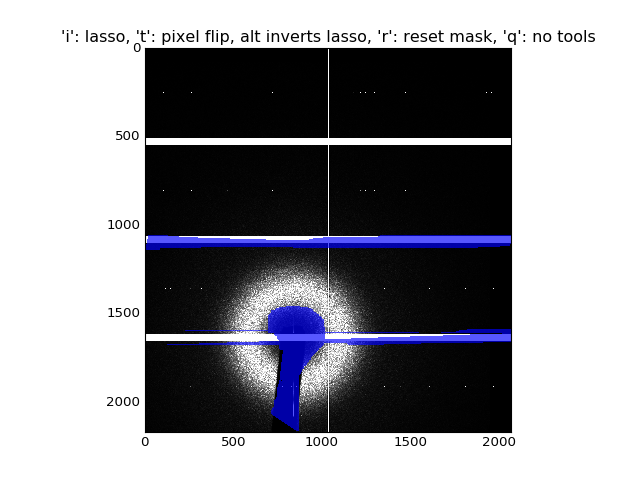

In [38]:
% matplotlib notebook

m = ManualMask(avg_img, vmin=0, vmax=1e0)

## Input the mask file

In [46]:
cd sameera/Analysis_Pipelines/

/home/sameera/Analysis_Pipelines


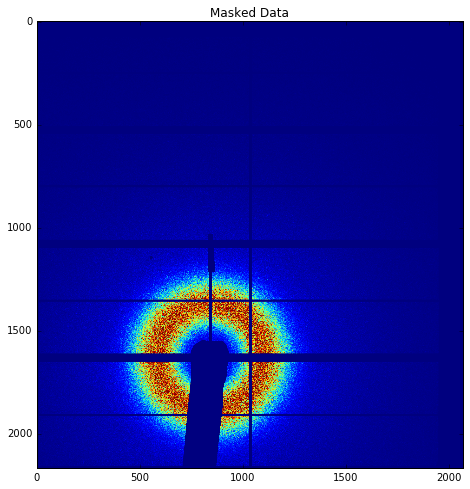

In [47]:
%matplotlib inline

mask = ~np.load("./mask2.npy")

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(avg_img*mask, vmin=0, vmax=1e0)
ax.set_title("Masked Data")
plt.show()

## Get the approximate center and see the statistic to make sure 

In [48]:
center = (1634.66, 838.6)  # center of the speckle pattern

### Circular Average : compute the radial integartion of image data from the center of the speckle pattern

In [49]:
bin_centers, ring_averages= roi.circular_average(avg_img*mask, center, threshold=0, nx=100,
                                         pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

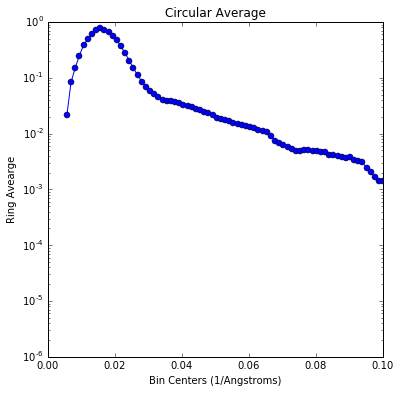

In [50]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.1)
plt.show()

## Plot Kymograph (Waterfall plot) for a vertical and hortizontal cuts]


Note : Give coordinates of the upper-left corner and width and height of each
rectangle: e.g., [(x, y, w, h), (x, y, w, h)]


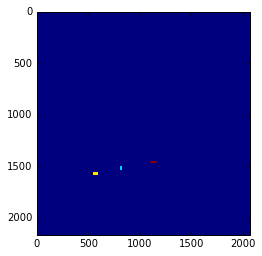

In [51]:
vert_rect = ((1500, 803, 40, 20), (1554, 546, 30, 40), (1454, 1098, 20, 60)) 

V_K_label_array = roi.rectangles(vert_rect, avg_img.shape)

plt.imshow(V_K_label_array)
plt.show()

In [54]:
veri_kymo = roi.kymograph(imgs, V_K_label_array*mask, num = 1)

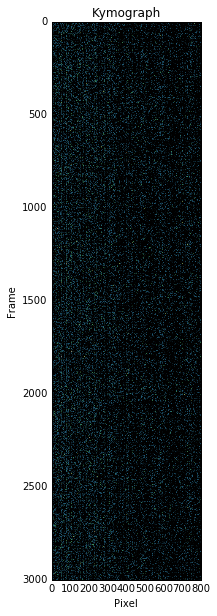

In [55]:
fig, ax = plt.subplots(figsize=(14,10))
ax.set_xlabel('Pixel')
ax.set_ylabel('Frame')
ax.set_title('Kymograph')
ax.imshow(veri_kymo, cmap='gist_earth')
plt.show()

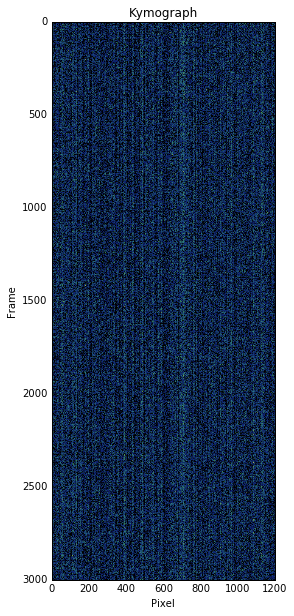

In [56]:
hori_kymo = roi.kymograph(imgs, V_K_label_array*mask, num=2)

fig, ax = plt.subplots(figsize=(14,10))
ax.set_xlabel('Pixel')
ax.set_ylabel('Frame')
ax.set_title('Kymograph')
ax.imshow(hori_kymo, cmap='gist_earth')
plt.show()

##  Mean intensities for each ring

In [57]:
inner_radius = 88# radius of the first ring
width = 1        # width of each ring
spacing = 1      # no spacing between rings
num_rings = 10    # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[  88.,   89.],
       [  90.,   91.],
       [  92.,   93.],
       [  94.,   95.],
       [  96.,   97.],
       [  98.,   99.],
       [ 100.,  101.],
       [ 102.,  103.],
       [ 104.,  105.],
       [ 106.,  107.]])

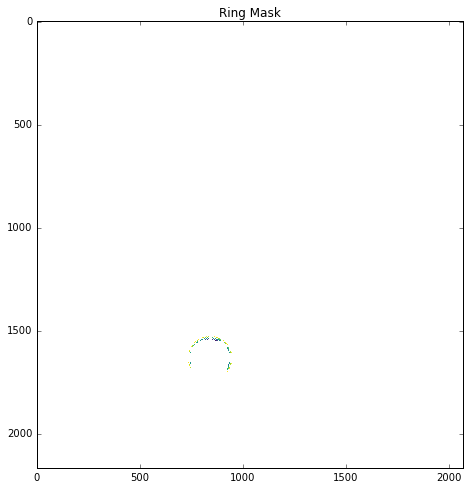

In [58]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask

# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Ring Mask")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis')
plt.show()

In [59]:
mask_data = imgs*mask
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

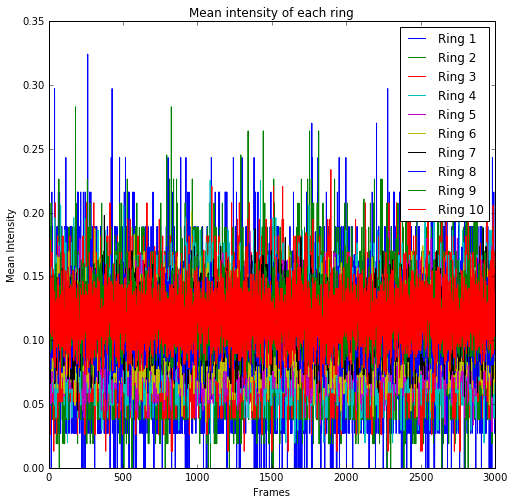

In [68]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Frames")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()


## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [69]:
num_lev = 9  
num_buf = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf, ring_mask,
                                             mask_data)

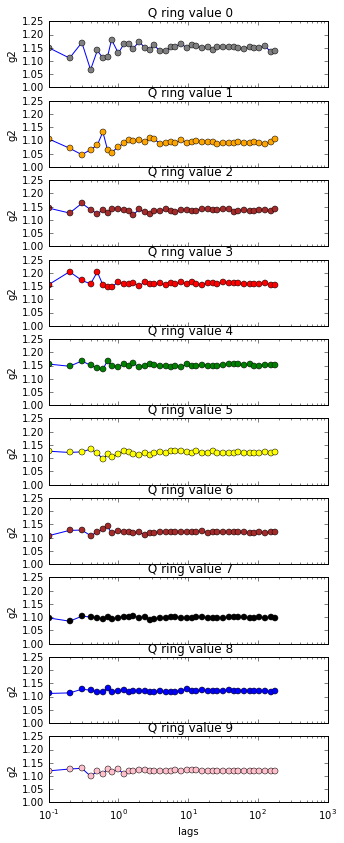

In [70]:
lags = lag_steps*timeperframe

roi_names = ['gray', 'orange', 'brown', 'red', 'green', 'yellow', 'brown', 'black', 'blue', 'pink']

fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5, 14))
axes[num_rings-1].set_xlabel("lags")
for i, roi_color in zip(range(num_rings), roi_names):
    axes[i].set_ylabel("g2") 
    axes[i].set_title(" Q ring value " + str(i))
    axes[i].semilogx(lags, g2[:, i], '-o', markerfacecolor=roi_color, markersize=6)
    axes[i].set_ylim(bottom=1, top=np.max(1.25))
plt.show()